<a href="https://colab.research.google.com/github/yurisugano/Object-Ellicitation-NLP/blob/main/2023_ObjectEllicitationAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preface:

Start by copying this colab to your Drive in "File" > "Save a copy in Drive". This allows you to modify the code.

Run code by pressing play in each cell. Results will be shown immediately after the code. Press play in the cell below to run it. The cell will download the Transcript data from GitHub. and print "done".


In [ ]:
%%capture
!rm -rf ObjectEllicitationNLP
!git clone https://github.com/yurisugano/ObjectEllicitationNLP.git

print("done")

# Step 1: Text cleaning


## 1.1 Loading the data

Load the transcript data and organize its structure.

1. Read the `Transcripts.docx` file into a `doc` object.
2. Each paragraph in the `doc` object corresponds to one sentence stated by a subject
3. Format so all subject and object notation is consistent:
  - Enclose all three digit numbers that are not enclosed in curly braces
  - Remove spaces and dashes
4. Lastly, all sentences said by a subject are grouped together. Specifically, each dictionary object will be in the format of `{'speaker': "SpeakerID", 'sentence': <"Everything subject has said"> o, 'objects': <"All object references">}`.

---
ℹ️ In the code, packages used in the block are imported first. Then, functions that perform the manipulations are defined. Lastly, a for loop applies these functions to each paragraph in the transcript.

It is a good habit to include a sentence describing what a function does as a comment in the first line of its definition.

---

In [ ]:
# Load necessary packages
!pip install python-docx
import re
from docx import Document

# Read the transcript from the cloud
raw_data = Document('/content/ObjectEllicitationNLP/Transcripts.docx')


# Define functions to handle formatting
def add_curly_braces(paragraph_text):
    """Add curly braces to three-digit numbers not surrounded by square brackets or curly braces."""
    numbers = re.findall(r'(?<![\[{])\b(\d{3})\b(?![\]}])', paragraph_text)
    for number in numbers:
        transformed_number = '{' + number + '}'
        paragraph_text = re.sub(r'\b' + number + r'\b', transformed_number, paragraph_text)
    return paragraph_text

def handle_square_brackets(paragraph_text):
    """Handle numbers inside square brackets with optional spaces and dashes."""
    matches = re.findall(r'\[([\d\s,-]+)\]', paragraph_text)
    for match in matches:
        numbers = []
        for num_range in re.split(r',\s*|\s+', match):
            num_range = num_range.strip()
            if '-' in num_range:
                start, end = num_range.split('-')
                numbers.extend(range(int(start), int(end) + 1))
            else:
                numbers.append(int(num_range))

        transformed = '[' + ']['.join(map(str, numbers)) + ']'
        paragraph_text = paragraph_text.replace('[' + match + ']', transformed)
    return paragraph_text

# Iterate over each paragraph
for each_paragraph in raw_data.paragraphs:
    each_paragraph.text = add_curly_braces(each_paragraph.text)
    each_paragraph.text = handle_square_brackets(each_paragraph.text)



In [ ]:
# Visualize what one paragraph looks like
print(raw_data.paragraphs[4].text)

Now, each paragraph consists of a subject identifier e.g. `{104}` and a single sentence. We need to gather all the sentences for each subject.

## 1.2 Extracting Subjects and Sentences


1. Loop through each paragraph again, now extracting
  - `speaker` with all three digit numbers surrounded by `{ }`
  - `sentence` for the entire string after `:`
  - `objects` for all three digit numbers surrounded by `[ ]`

2. Concatenate alll sentences by the same speaker in a single string.
3. Lastly, create a dictionary named `data`, organized as follows:
  `{subjectID: {subjectID: subjectID, statements: ["Statement1", "Statement2", ...], objects: [201, 202, ...]}`
  - All objects are listed in the order they appear. Repeats are allowed so we can, for example, easily determine which objects are more popular

In [ ]:
def extract_info(paragraph_text):
    """Extract speaker, sentences, and objects from a paragraph text."""
    speaker_match = re.search(r'\{(\d{3})\}', paragraph_text)
    sentence_match = re.search(r': (.*)', paragraph_text)
    objects_match = re.findall(r'\[(\d{3})\]', paragraph_text)

    if speaker_match and sentence_match:
        speaker = speaker_match.group(1)
        sentence = sentence_match.group(1)
        objects = [int(object_id) for object_id in objects_match]
        return speaker, sentence, objects
    else:
        return None, None, None


def update_data(data, speaker, sentence, objects):
    """Update data dictionary with extracted speaker, sentence, and objects."""
    if speaker:
        if speaker in data:
            data[speaker]['statements'].append(sentence)
            data[speaker]['objects'].extend(objects)
        else:
            data[speaker] = {'subject': speaker, 'statements': [statement], 'objects': objects}

# Initialize an empty dictionary to store the data
data = {}

# Loop over each paragraph in the document
for each_paragraph in raw_data.paragraphs:
    speaker, statement, objects = extract_info(each_paragraph.text)
    update_data(data, speaker, statement, objects)

The data is now organized in a dictionary.

Now, each row in the dictionary has a speaker tag, all the sentences stated by that speaker, and the objects referenced within that paragraph. This is a quick way to check if a subject has mentioned all the objects. Let's look at an entire sentence using subject 106 as an example.

In [ ]:
print(data['106']['statements'])
print(data['106']['statements'][10])


# Step 2: Pre-processing #


## 2.1: Word tokenization

The first step is to separate the entire speech in its individual components. These components are called **tokens**. Tokens may include individual words, but also commas and punctiation. Let's grab the one random sentence as an example


In [ ]:
# Pick subject 104 sentence id 16 as an example
sentence = data['104']['statements'][16]

print(sentence)


1. Use the package `nltk` to convert the sentence to tokens using the `word_tokenize()` method.

Display the first 10 elements (`[:9]`)


In [ ]:
# Import the nltk library
import nltk

# Download the 'punkt' library, used for tokenization
nltk.download('punkt')

# Tokenize the example sentnece
sentence_tokens = nltk.word_tokenize(sentence)

# Print the first 10 tokens
print(sentence_tokens[:9])

Object references such as [220] are being treated as tokens. To create a purely text string, let's create a new key inside the dictionary called `statement_clean`, and remove all references to objects or speakers.

In [ ]:
# Loop through each subject : subject_data pair in the data dictionary
for subject, subject_data in data.items():
    statements = subject_data["statements"]
    cleaned_statements = []

    # Loop through each sentence and remove references to objects
    for sentence in statements:
        cleaned_sentence = re.sub(r'\{.*?\} | \[.*?\]', "", sentence)
        cleaned_statements.append(cleaned_sentence)

    subject_data["clean_statements"] = cleaned_statements

clean_sentence = data['104']['clean_statements'][16]
print(clean_sentence)

Good, now every sentence is plain text. Back to tokenization

In [ ]:
# Tokenize the example sentence, now clean
sentence_tokens = nltk.word_tokenize(clean_sentence)

print(sentence_tokens[:9])

2. Create a new `key: value` pair inside our dictionary to group all tokens for each subject

In [ ]:
# Loop through eac subject : subject_data pair
for subject, subject_data in data.items():
    # Initialize an empty all_tokens list
    all_tokens = []

    # Store all the tokens in the all_tokens list with the .extend method
    for sentence in subject_data["statements"]:
        all_tokens.extend(nltk.word_tokenize(sentence))
    # Add the entry to the dictionary
    subject_data["all_tokens"] = all_tokens

print(data['104']['all_tokens'][:9])


**Important**: The choice of tokenizer is not arbitrary. There are different ways to tokenize text. For example:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I didn't even see that.

Could be tokenized as

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [I, didn't, even, see, that.]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [I, did, n't, even, see, that, .]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [I, didn, ', t, even, see, that, .]

And many others. The "right" tokenizer greatly depends on what analysis happens next. For instance, you want to use the same tokenizer that was used to train a model if you are applying that model in your data.

Without worrying too much about which tokenizer, we will use NLTK's standard version and change it whenever we need.

## 2.2 Case-folding

For analyzes where case doesn't matter, we can convert all tokens to lower-case


In [ ]:
# Loop through each subject, transforming all tokens to lower case
for subject, subject_data in data.items():
    subject_data['all_tokens_lower'] = [token.lower() for token in subject_data['all_tokens']]

print(data['104']['all_tokens_lower'][:9])


## 2.3 Stop word removal

For some analysis words such as "the", "and", "a", etc. are not informative. We can use nltk's stopword data base and remove all the stop words in the statements.

In [ ]:
# Load the stopwords corpus
from nltk.corpus import stopwords

# Download the list of stop words
nltk.download('stopwords')

# Store the list of stop words in the object stop_words
stop_words = set(stopwords.words('english'))

# Loop through each subject, removing all stop words
for subject, subject_data in data.items():
    subject_data['all_tokens_no_stops'] = [token for token in subject_data['all_tokens_lower']
                                           if token not in stop_words]

print(data['104']['all_tokens_no_stops'][:9])


## 2.4 Stemming and lemmatization

The tokens "Looking" "look" and "looked" all mean the same thing if the analysis is concerned with "usage of the word look".

One way to accomplish this is through stemming: reducing the word to its stem.

A more robust way to do this is to reduce the word to its lemma. In short, stemming is simply cutting the word following certain rules, while lemma uses a wider set of rules to arrive at a word's meaningful base form. For instance:

* Stemming "Caring" and "Cared" might lead to "Car"
* Lemmatizing "Caring" and "Care" will produce "Care"

We will keep a copy of our lemmatized tokens

In [ ]:
# Import nltk's lemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

for subject, subject_data in data.items():
      subject_data['all_tokens_lemmatized'] = [lemmatizer.lemmatize(token)
                                               for token in subject_data['all_tokens_no_stops']]


print(data['104']['all_tokens_lemmatized'][:9])

## 2.5 Removing punctuation

For basic analysis such as frequency of words, punctuation might not be relevant.

In [ ]:
import string

for subject, subject_data in data.items():
  subject_data['all_tokens_clean'] = [token for token in subject_data['all_tokens_lemmatized']
                                      if token not in string.punctuation]

print(data['104']['all_tokens_clean'][:9])

Some tokens are still not meaningful such as `'` or `1`. But we can deal with them later :)


## 2.6 Sentence tokenization

We can (and we certainly will) perform analysis at the level of individual words. However, individual sentences are another natural way to "chunk" the text. Individual sentences, rather than individual word tokens, can be more informative when context is important. This is certainly true for clustering and classification.

Luckily, nltk provides a `sent_tokenizer()` function

In [ ]:
for subject, subject_data in data.items():
    sentence_tokens = []

    for sentence in subject_data["statements"]:
        sentence_tokens.extend(nltk.sent_tokenize(sentence))
    subject_data["sentence_tokens"] = sentence_tokens

print(data['104']['sentence_tokens'][:9])


Now, each token is an individual sentence.

We can take advantage of nesting lists and dictionaries and create yet a new token: individual words within individual sentences. To do this, simply create all `word_tokens` for each `sentence_tokens`

In [ ]:
for subject, subject_data in data.items():
    word_tokens = []

    for sentence_token in subject_data["sentence_tokens"]:
        word_tokens.append(nltk.word_tokenize(sentence_token))

    subject_data["word_tokens"] = word_tokens

print(data['104']['word_tokens'][:9])


---
ℹ️ We have performed sequential operations during the pre-processing stage, and this is often the case. The steps and the details of each step (for instance, what tokenizer to use, or whether to remove stop words) depends largely on the analysis that will follow.

These sequential operations are called **pipelines** in NLP. During actual analysis, we will determine the specific pipeline for a project and perform all steps within a single for loop.

As such, this section provides an overview of how all analyses will start. Each analysis starts with a pre-processing block using a combination of some or all of the steps delineated here.

---

# Step 3: Feature extraction

Computers being unable to understand words might be the fundamental challenge in NLP.

Before analysis, we will try to come up with ways to find representations for the data so that

1. The computer can interpret and make calculations with the representation
2. The representation carries some meaning

Feature extraction is arguably the most challenging and important part of any NLP (in fact, of all machine learning) projects. **Feature engineering** is the discipline that focuses on this particular challenge.

We will use some commonly used feature extraction methods here. However, a solid project will often rely on new features custom for that project.

## 3.1 POS-tagging

One relevant feature we can extract from the text is the part of speech (POS). We can easily include data for the part of speaech using a POS (part-of-speech) tag.

We will use nltk's averaged perceptron tagger which is a machine learning algorithm. It was trained on a large labeled database, and we are extending its capacity to generalize to our text. For detailed info on the averaged perceptron tagger, look [here](https://explosion.ai/blog/part-of-speech-pos-tagger-in-python)

First, we inspect how the `pos_tag()` output looks like with the example sentence


In [ ]:
# Download the average perceptron tagger
nltk.download('averaged_perceptron_tagger')

example_postag = nltk.pos_tag(sentence_tokens)

pprint.pprint(example_postag)

Below is a summary of the POS tags.


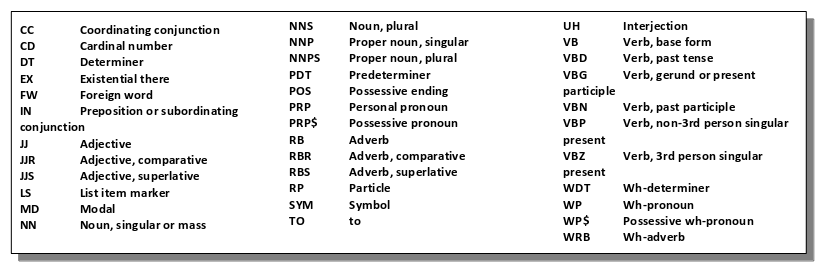

Now we can store the entire POS-tag data for each subject. As always, we will create a new entry in the dictionary for that. We will use the main `all_tokens` and not any of the cleaned versions in this example.


In [ ]:
# Loop through each subject, adding all the pos tags
for subject, subject_data in data.items():
    pos_tag = []
    for word_token in subject_data["word_tokens"]:
        pos_tag.append(nltk.pos_tag(word_token))

    subject_data["postag"] = pos_tag


print(data['104']['postag'][:9])

Note that the POS-tagger wrongly classified sounds (a verb) as a plural noun. Visual inspection is fundamental at every stage.

Carefully organizing your pipeline will maximize the likelihood of good labeled data. For every algorithm, look at what steps were used in the pipeline of the training data used by the algorithm.

In the context of feature extraction, we can assign numbers to different POS-tags, and we can feed that information to the computer. So now each subject's sentence is a string of numbers corresponding to the part-of-speech. We could use this data to analyze sentence structure, look at modal verbs, etc.

## 3.2 Vectorization


Another way to represent language data is through a vector. Each vector is an array of numbers. Each word (or sentence, or whatever unit of analysis) can be represented by a vector in n dimensions, where n is the number of features.

### Theoretical example
For instance, let's say we have two features:
1. whether a token is a verb or not (represented by 1 or 0)
2. whether that token represents something related to sensation (on an arbitrary scale from 0 to 1, where 0 means not at all related to sensation, and 1 is an explicit sensory word).

Now, each subject's tokens are represented by a two-dimensional vector. Let's look at a theoretical example:

In [ ]:
hypothetical_vectorization = {
    501: {
        'sentences': ["I see water", "I smell bugs"],
        'vectors': [[[0, 0.5], [1, 0.97], [0, 0.1]],
                    [[0, 0.5], [1, 0.99], [0, 0.5]]]
    },
    502: {
        'sentences': ["Cars are fast", "Ball is round"],
        'vectors': [[[0, 0.2], [1, 0.1], [0, 0.3]],
                    [[0, 0.4], [1, 0.1], [0, 0.8]]]
    }
}

pprint.pprint(hypothetical_vectorization)

The hypothetical algorithm ranked verbs correctly. It assigned a high sensory score to words "see" and "smell", a somewhat high score to "round" and "bugs" and a low score to "cars" and "ball". Let's pretend this all makes sense.

How are vectors useful?

First, vectors can be represented in n-dimensional space. In other words, now each token is represented in space. We can, for example:

1. Estimate a sentence's location by the average position of its tokens
2. Estimate similarity between sentences
3. Estimate how "sensory" someone is based on how far to the sensory side of the scale their vectors tend to lie

In our convenient example, we can easily visualize the vectors in two dimensions

In [ ]:
fig, ax = plt.subplots()

# Iterate at each sentence key: value pair
for key, value in hypothetical_vectorization.items():
    sentences = value['sentences']
    vectors = value['vectors']

    for i, sentence in enumerate(sentences):
        for j, vector in enumerate(vectors[i]):
            if key == 501:
                ax.plot(vector[0], vector[1], 'o', label=f'{sentence.split()[j]}: {vector}', color='red')
            elif key == 502:
                ax.plot(vector[0], vector[1], 'o', label=f'{sentence.split()[j]}: {vector}', color='blue')

ax.set_xlabel('Verb')
ax.set_ylabel('Sensory')
ax.legend()

plt.show()

From this simple example, we can get a sense of what words are similar, create a general profile for each sentence, for each subject based on its average position, cluster words/sentences together or even classify a new word based on its features.

Evidently, real examples contain many more than two features and can't be easily visualized. But the underlying principles are the same: we can ask questions about categories based on where tokens are in n-dimensions. We can also calculate distance between tokens, sentences or subjects.

### Real example: Bag of Words

We will use a more efficient way to create features than inventing (and giving values to) our own.

The most basic vectorizer is a count vectorizer. It takes each word in the corpus as a feature. Then it counts how many times each word is said in a sentence.

The vector representation is a n-sized vector where n is the number of unique words on the entire document.

Let's vectorize our real data. First, remember all the keys we added so far with the `.keys()` method.

In [ ]:
print(data['104'].keys())

We will vectorize the `all_tokens_clean` list.

1. Write a corpus consisting of all unique tokens
2. Use the `CountVectorizer` module to get counts for each subject
3. Construct a BoW representation where each row is a subject and each column is a unique token. Each cell `n, m` is the count of how many times subject `n` said the word `m`.
4. Inspect the data with `pandas.head()` command, which displays the first few rows

---
ℹ️ Pandas is a widely used package used to work with data frames. Pandas data frames work similarly to excel sheets, with data organized in rows and columns.

---


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Prepare a corpus using the tokens for each subject, and keep track of the IDs
ids = []
corpus = []
for subject, subject_data in data.items():
    ids.append(subject)
    corpus.append(' '.join(subject_data['all_tokens_clean']))

# Transform the corpus into a bag of words
BoW = vectorizer.fit_transform(corpus)

# Convert the matrix to a DataFrame and set row (index) names to subjectIDs
BoW = pd.DataFrame(BoW.toarray(),
                   index=ids,
                   columns=vectorizer.get_feature_names_out())


BoW.head()

# Step 4: Analysis!

Now to the fun part. We can use the features we extracted to learn something from the data.

Let's start getting some basic information:

1) How many tokens did each subject say?


In [ ]:
verbose = {}

for subject, subject_data in data.items():
    # Create a new dictionary for each subject
    verbose[subject] = {
        'token_length': len(subject_data['all_tokens']),
    }

pprint.pprint(verbose)

2) How about the frequency of verbs for each subject?

In [ ]:
for subject, subject_data in data.items():
    # Initialize a counter
    verb_count = 0
    # Iterate over each sentence
    for sentence in subject_data['postag']:
        # Iterate over each pair (token, POS_tag)
        for pos_tuple in sentence:
            # Count if the token is a verb
            if pos_tuple[1] == 'VB':
                verb_count += 1

    # Create an output with all the data
    verbose[subject] = {
        'token_length': len(subject_data['all_tokens']),
        'verb_count': verb_count,
        'verb_fraction': verb_count / len(subject_data['all_tokens'])
    }

pprint.pprint(verbose)

It is useful to know how to convert from a dictionary to a pandas data frame

In [ ]:
verbose = pd.DataFrame(verbose).T
verbose.head()

We can use a boxplot to investigate the frequency of verbs and if anyone tends to use them too often

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(y='verb_fraction', data=verbose, color='lightblue', width=0.3)

# Add text at each data point
for i in range(verbose.shape[0]):
    plt.text(x=0, y=verbose['verb_fraction'].iloc[i],
             s=verbose.index[i], color='black', size=8)

plt.title('Boxplot with Data Points as Text')
plt.xlabel('Subjects')
plt.ylabel('Verb Fraction')

plt.show()

During the actual analysis, we might want to exclude the interviewer :)

3. How about the frequency of words? That's easy once we have a BoW object

In [ ]:
# Create a ordered BoW object, summing across all subjects
overall_frequency = BoW.sum().sort_values(ascending=False)

# Get the most frequent 20 words
print(overall_frequency[:20])

# Get the least frequent 10 words
print(overall_frequency[-10:])

Objects 217 and 218 appear to be particularly popular!

4. Distribution of object references per person

In [315]:
from collections import Counter

# Create an empty dictionary to hold the frequency of objects
object_frequencies = {}

for subject, subject_data in data.items():

  object_counter = Counter(subject_data['objects'])
  total = sum(object_counter.values())
  object_proportions = {k: v/total for k, v in object_counter.items()}

  object_frequencies[subject] = {
      'object_frequency': object_counter.most_common(),
      'object_proportion': sorted(object_proportions.items(), key=lambda item: item[1], reverse=True)
  }

# Create DataFrame
df = pd.DataFrame([
    {
        'subject': subject,
        'object_proportion': subject_data['object_proportion']
    }
    for subject, subject_data in object_frequencies.items()
])

import pprint
pprint.pprint(object_frequencies)
print(df.head())


{'000': {'object_frequency': [(201, 1),
                              (203, 1),
                              (205, 1),
                              (206, 1),
                              (207, 1),
                              (208, 1)],
         'object_proportion': [(201, 0.16666666666666666),
                               (203, 0.16666666666666666),
                               (205, 0.16666666666666666),
                               (206, 0.16666666666666666),
                               (207, 0.16666666666666666),
                               (208, 0.16666666666666666)]},
 '104': {'object_frequency': [(217, 10),
                              (202, 8),
                              (222, 8),
                              (205, 7),
                              (206, 7),
                              (208, 7),
                              (218, 7),
                              (221, 7),
                              (201, 6),
                              (223, 6),
  

5. How about the most frequent words per person?

In [ ]:
# 2) Calculate the ordered frequency for each row in X
individual_frequencies = {}
for subject in BoW.index:
    sorted_freq = BoW.loc[subject].sort_values(ascending=False)
    individual_frequencies[subject] = sorted_freq

# Display the top 5 words for each subject
for subject, freq in individual_frequencies.items():
    print({subject})
    print(freq[:5])

# Summary

These steps cover the initial steps to most language processing analyses. To recap, here's a summary of all the steps. While the order presented here corresponds to implementation, the order is shifted during planning:

1. Determine what features are relevant for the analyses. The features should be numerical representation of the data, and should be informative to the specific goals of the analysis.
2. Create a pre-processing pipeline, including all relevant transformations. This should happen on paper first.
  * The pipeline should be decided based on the goal of the analyses
  * The models used also dictate what type of pre-processing is required
  * Realistically, each project will have its own pipeline. Some steps will be common, while others specific to a project.
  * Sometimes, a project may require a custom pre-processing stage.


Only at this stage we can start to write code

3. Clean the text, paying particular attention to patterns we want to exclude (or make sure we include) based on the goal of our analysis.


3. Once the pipeline has been established, we can implement on the cleaned dataset.
  * At this stage, visual inspection is the best way to make sure everything has been processed as intended
  * It is useful to include some check blocks before starting feature extraction, such as counting how many times the character `.` appears, after attempting to remove it.

4. Extract the features from the text.
  * This may be done using common approaches such as POS-tagging or BoW, or through custom features
  * Often relevant features from a project can be obtained from other commonly used features (such as the feature "frequency of verbs" from tokenization and POS-tags)

5. Answer the initial questions through analysis of the vectorized texts
  * Sometimes interpretability may be difficult. In general, the more information behind a vectorization step, the less interpretable it becomes. In such cases, we will rely on metrics such as distance, clusters or categories without actually visualizing the vectors.